# 国债期货成交明细日报

In [2]:
import numpy as np
import pandas as pd
import datetime
from openpyxl.reader.excel import load_workbook as lw
from WindPy import *
import matplotlib.pyplot as plt
import pymysql
from pylab import *
from matplotlib.font_manager import FontProperties  
%matplotlib inline

w.start()

codelist = ['T2209.CFE','T2212.CFE','T2303.CFE','T2306.CFE']
codelist2 = ['TF2209.CFE','TF2212.CFE','TF2303.CFE','TF2306.CFE']
codelist3 = ['TS2209.CFE','TS2212.CFE','TS2303.CFE','TS2306.CFE'] #所有国债合约

#date = ['20220121','20220124','20220125','20220126','20220127','20220128','20220207','20220208','20220209','20220210','20220211',
#        '20220214', '20220215', '20220216', '20220217', '20220218', '20220221', '20220222']

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


## T

In [3]:
result = pd.DataFrame(columns = ['合约','T主连价格','空开-多开（累计值）','多平-空平（累计值）','净空方力量（累计值）','空多比'])

# wind提取主力合约的价格
start =  ["2022-01-01","2022-09-30"]
end = ["2022-01-01","2022-09-30"]
n = len(start)
date = []
for i in range(n):
    data_raw = w.wsd(codelist[i], "His_close", start[i], end[i], "Fill=Previous")
    table_comp = pd.DataFrame(columns = ['合约','T主连价格'], index = data_raw.Times)
    table_comp['合约'] = [data_raw.Codes[0] for j in range(len(data_raw.Times))]
    table_comp['T主连价格'] = data_raw.Data[0]
    
    date.append([i.strftime("%Y%m%d")for i in data_raw.Times])
    
    result = pd.concat([result,table_comp],axis = 0,ignore_index = False)

In [4]:
# 连接sql数据库
conn = pymysql.connect(
    host='localhost',
    user='root',
    passwd="axzgsqlsjk", #数据库密码
    db='axzg-国债期货成交明细' #数据库名称
)

OperationalError: (2003, "Can't connect to MySQL server on 'localhost' ([WinError 10061] 由于目标计算机积极拒绝，无法连接。)")

In [4]:
duokai = []
kongkai = []
duoping = []
kongping = []

for i in range(n):
    code = codelist[i].split(".CFE")[0]
    for j in date[i]:
        try:
            # 多开
            select1 = '''SELECT `现手`  FROM `%s-%s` WHERE `性质`= "多开" ''' %(j,code)
            select2 = '''SELECT `增仓`  FROM `%s-%s` WHERE `性质`= "多开" ''' %(j,code) 
            df = pd.concat([pd.read_sql(select1,conn),pd.read_sql(select2,conn)],axis = 1)
            df = df.astype(int)
            duokai.append(((df['现手']-df['增仓'].abs())*2).sum())

            # 空开
            select1 = '''SELECT `现手`  FROM `%s-%s` WHERE `性质`= "空开" ''' %(j,code)
            select2 = '''SELECT `增仓`  FROM `%s-%s` WHERE `性质`= "空开" ''' %(j,code) 
            df = pd.concat([pd.read_sql(select1,conn),pd.read_sql(select2,conn)],axis = 1)
            df = df.astype(int)
            kongkai.append(((df['现手']-df['增仓'].abs())*2).sum())

            # 多平
            select1 = '''SELECT `现手`  FROM `%s-%s` WHERE `性质`= "多平" ''' %(j,code)
            select2 = '''SELECT `增仓`  FROM `%s-%s` WHERE `性质`= "多平" ''' %(j,code) 
            df = pd.concat([pd.read_sql(select1,conn),pd.read_sql(select2,conn)],axis = 1)
            df = df.astype(int)
            duoping.append(((df['现手']-df['增仓'].abs())*2).sum())

            # 空平
            select1 = '''SELECT `现手`  FROM `%s-%s` WHERE `性质`= "空平" ''' %(j,code)
            select2 = '''SELECT `增仓`  FROM `%s-%s` WHERE `性质`= "空平" ''' %(j,code) 
            df = pd.concat([pd.read_sql(select1,conn),pd.read_sql(select2,conn)],axis = 1)
            df = df.astype(int)
            kongping.append(((df['现手']-df['增仓'].abs())*2).sum())
            
        except:
            duokai.append(0)
            kongkai.append(0)
            duoping.append(0)
            kongping.append(0)

duokai = np.add.accumulate(np.array(duokai))
kongkai = np.add.accumulate(np.array(kongkai))
duoping = np.add.accumulate(np.array(duoping))
kongping = np.add.accumulate(np.array(kongping))

result['空开-多开（累计值）'] = kongkai-duokai
result['多平-空平（累计值）'] = duoping-kongping
result['净空方力量（累计值）'] = result['空开-多开（累计值）'] + result['多平-空平（累计值）']
result['空多比'] = (kongkai+duoping)/(duokai+kongping)

In [5]:
result

,合约,T主连价格,空开-多开（累计值）,多平-空平（累计值）,净空方力量（累计值）,空多比
2022-01-21,T2203.CFE,101.380,-3860,758,-3102,0.872398
2022-01-24,T2203.CFE,101.500,-3432,4536,1104,1.023952
2022-01-25,T2203.CFE,101.520,-4922,5984,1062,1.015288
2022-01-26,T2203.CFE,101.245,1898,4106,6004,1.060815
2022-01-27,T2203.CFE,101.115,5556,4756,10312,1.085215
...,...,...,...,...,...,...
2022-05-05,T2206.CFE,100.450,52260,11436,63696,1.045832
2022-05-06,T2206.CFE,100.500,50460,11622,62082,1.043792
2022-05-09,T2206.CFE,100.590,47862,10952,58814,1.040990
2022-05-10,T2206.CFE,100.705,44830,12610,57440,1.039450


In [6]:
# commit 提交
conn.commit()
# 关闭MySQL链接
conn.close()

# 作图

## 多空力量对比1和期货价格（净空方力量）

In [7]:
#支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

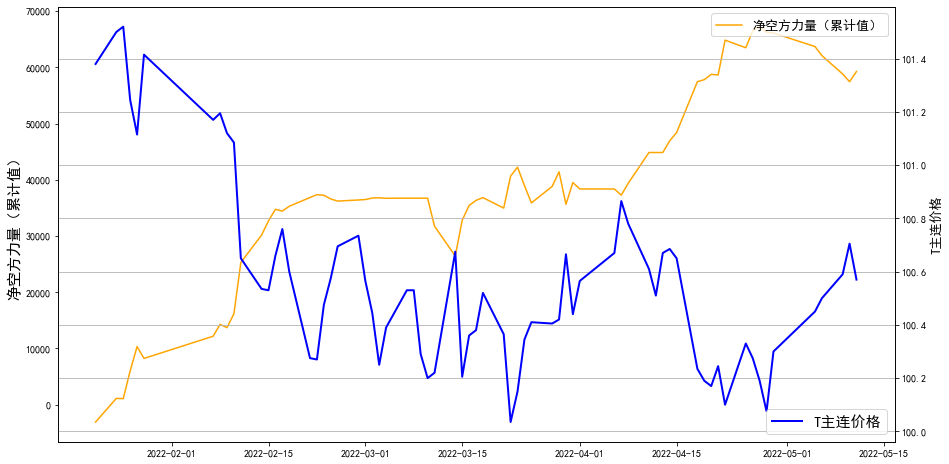

In [8]:
x = result.index
y1 = result['T主连价格']
y2 = result['净空方力量（累计值）']

fig,ax1=plt.subplots(figsize = (15,8))
ax1.plot(x,y2,c='orange', linewidth = 1.5)
ax1.set_ylabel('净空方力量（累计值）',size = 15)
plt.legend(labels=['净空方力量（累计值）'],loc="upper right",fontsize=13)
ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要
ax2.plot(x,y1,c='b',linewidth = 2)
ax2.set_ylabel('T主连价格',size = 13)
plt.legend(labels=['T主连价格'],loc="lower right",fontsize=15)
plt.grid(True)  # 样式风格：网格型
plt.show()

## 多空力量对比2和期货价格（分解）

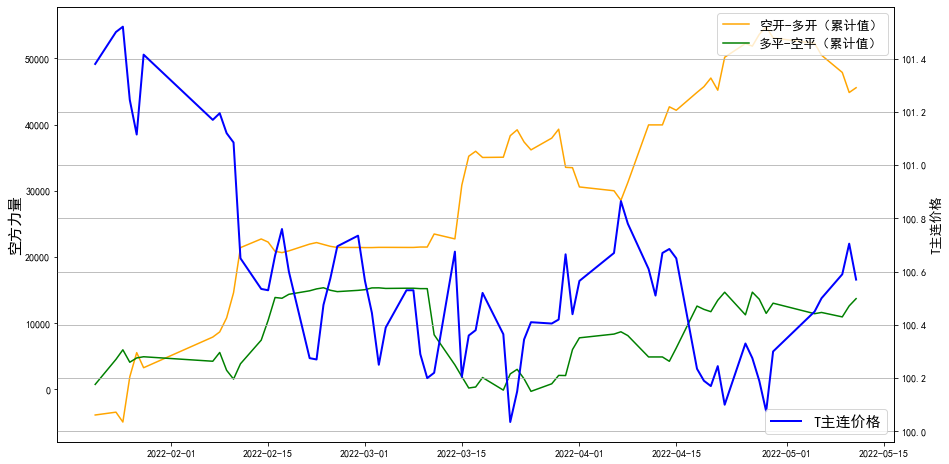

In [9]:
x = result.index
y1 = result['T主连价格']
y2 = result['空开-多开（累计值）']
y3 = result['多平-空平（累计值）']

fig,ax1=plt.subplots(figsize = (15,8))
ax1.plot(x,y2,c='orange', linewidth = 1.5)
ax1.plot(x,y3,c='g',linewidth = 1.5)
ax1.set_ylabel('空方力量',size = 15)
plt.legend(labels=['空开-多开（累计值）','多平-空平（累计值）'],loc="upper right",fontsize=13)
ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要
ax2.plot(x,y1,c='b',linewidth = 2)
ax2.set_ylabel('T主连价格',size = 13)
plt.legend(labels=['T主连价格'],loc="lower right",fontsize=15)
plt.grid(True)  # 样式风格：网格型
plt.show()

## 多空力量对比3和期货价格（空多比）

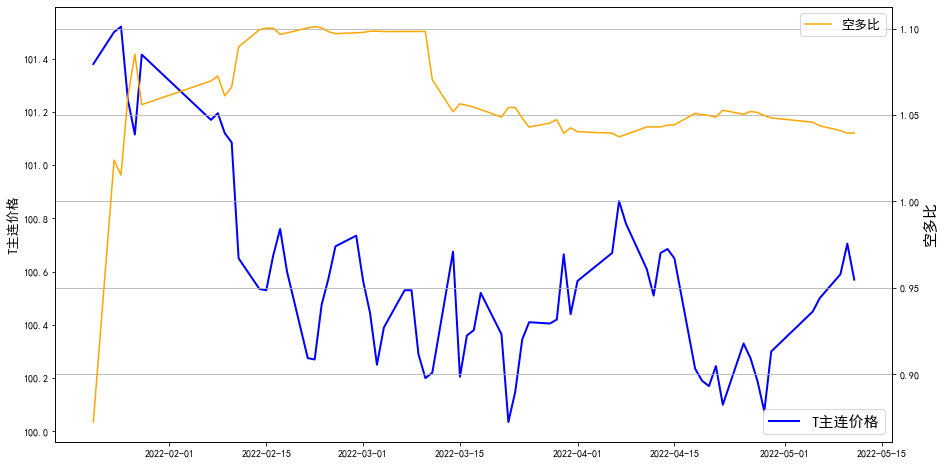

In [10]:
#table = pd.DataFrame(columns = ['合约','T主连价格','空开-多开（累计值）','多平-空平（累计值）','净空方力量（累计值）','多空比'])
x = result.index
y1 = result['T主连价格']
y2 = result['空多比']

fig,ax1=plt.subplots(figsize = (15,8))
ax1.plot(x,y1,c='b',linewidth = 2)
ax1.set_ylabel('T主连价格',size = 13)
plt.legend(labels=['T主连价格'],loc="lower right",fontsize=15)
ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要
ax2.plot(x,y2,c='orange', linewidth = 1.5)
ax2.set_ylabel('空多比',size = 15)
plt.legend(labels=['空多比'],loc="upper right",fontsize=13)
plt.grid(True)  # 样式风格：网格型
plt.show()

# 保存数据到excel

In [12]:
address = "D:/国债期货成交明细/"
file_name = "期货空多力量对比.xlsx"
result.to_excel(address+ file_name, index = True)